In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([.485, .456, .406], [.229, .224, .225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([.485, .456, .406], [.229, .224, .225])
    ]),
}

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                         data_transforms[x])
                 for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                                              batch_size=4,
                                              shuffle=True,
                                             num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0")

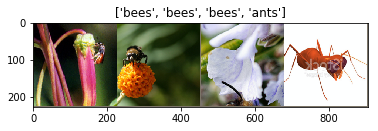

In [3]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([.485, .456, .406])
    std = np.array([.229, .224, .225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])
    

In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train() # Set model to training mode
            else:
                model.eval() # Set model to evaluate mode
            
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward pass: track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
        print()
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model
                

In [5]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [6]:
# Finetuning the convnet:
# Loading a pretrained model and resetting the final fully connected layer

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [7]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                      num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5661 Acc: 0.6803
val Loss: 0.3107 Acc: 0.8824

Epoch 1/24
----------
train Loss: 0.4376 Acc: 0.8033
val Loss: 0.2172 Acc: 0.9412

Epoch 2/24
----------
train Loss: 0.6215 Acc: 0.7582
val Loss: 0.2638 Acc: 0.9216

Epoch 3/24
----------
train Loss: 0.6587 Acc: 0.7623
val Loss: 0.6380 Acc: 0.7712

Epoch 4/24
----------
train Loss: 0.5742 Acc: 0.7623
val Loss: 0.6303 Acc: 0.8039

Epoch 5/24
----------
train Loss: 0.4645 Acc: 0.8279
val Loss: 0.2673 Acc: 0.8954

Epoch 6/24
----------
train Loss: 0.3392 Acc: 0.8648
val Loss: 0.4242 Acc: 0.8627

Epoch 7/24
----------
train Loss: 0.3916 Acc: 0.8525
val Loss: 0.3111 Acc: 0.9085

Epoch 8/24
----------
train Loss: 0.3106 Acc: 0.8770
val Loss: 0.3109 Acc: 0.9150

Epoch 9/24
----------
train Loss: 0.2991 Acc: 0.8566
val Loss: 0.3189 Acc: 0.9150

Epoch 10/24
----------
train Loss: 0.3112 Acc: 0.8811
val Loss: 0.2884 Acc: 0.9216

Epoch 11/24
----------
train Loss: 0.2939 Acc: 0.8689
val Loss: 0.2841 Acc: 0.9216

Ep

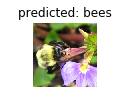

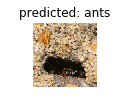

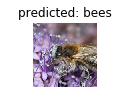

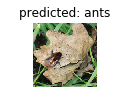

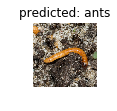

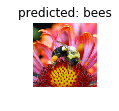

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f417e903e10>>
Traceback (most recent call last):
  File "/var/home/4thyr.oct2018/mtd38/marchantia-venv/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/var/home/4thyr.oct2018/mtd38/marchantia-venv/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 345, in get
    return ForkingPickler.loads(res)
  File "/var/home/4thyr.oct2018/mtd38/marchantia-venv/lib/python3.5/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.5/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/usr/lib/python3.5/multiprocessing/resource_sharer.

In [8]:
visualize_model(model_ft)

In [9]:
# Convnet as a fixed feature extractor
# Freeze all the network except the final layer

model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False # Freeze parameters so that gradients are not computed in backward()

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs,2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as 
# opposed to before
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [10]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                        exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.7141 Acc: 0.6516
val Loss: 0.2196 Acc: 0.9412

Epoch 1/24
----------
train Loss: 0.4767 Acc: 0.7459
val Loss: 0.1844 Acc: 0.9608

Epoch 2/24
----------
train Loss: 0.3764 Acc: 0.8361
val Loss: 0.2734 Acc: 0.8954

Epoch 3/24
----------
train Loss: 0.4353 Acc: 0.8320
val Loss: 0.1967 Acc: 0.9281

Epoch 4/24
----------
train Loss: 0.5044 Acc: 0.7828
val Loss: 0.1849 Acc: 0.9477

Epoch 5/24
----------
train Loss: 0.5513 Acc: 0.7869
val Loss: 0.1985 Acc: 0.9412

Epoch 6/24
----------
train Loss: 0.3519 Acc: 0.8402
val Loss: 0.2198 Acc: 0.9412

Epoch 7/24
----------
train Loss: 0.4001 Acc: 0.8115
val Loss: 0.2211 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.4019 Acc: 0.8197
val Loss: 0.1934 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.3483 Acc: 0.8320
val Loss: 0.1889 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.3798 Acc: 0.8279
val Loss: 0.2012 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.3177 Acc: 0.8279
val Loss: 0.1997 Acc: 0.9477

Ep

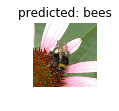

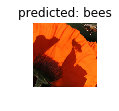

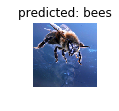

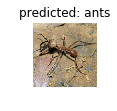

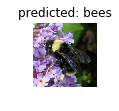

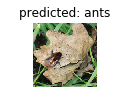

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f417e903d68>>
Traceback (most recent call last):
  File "/var/home/4thyr.oct2018/mtd38/marchantia-venv/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/var/home/4thyr.oct2018/mtd38/marchantia-venv/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 345, in get
    return ForkingPickler.loads(res)
  File "/var/home/4thyr.oct2018/mtd38/marchantia-venv/lib/python3.5/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.5/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/usr/lib/python3.5/multiprocessing/resource_sharer.

In [11]:
visualize_model(model_conv)

plt.ioff()
plt.show()